# Mutation Prediction from Gene Expression

This notebook demonstrates the complete workflow:
1. Load and preprocess TCGA expression and mutation data
2. Run k-fold cross-validation for mutation prediction
3. Combine predictions from all folds
4. Compute per-cancer-type metrics
5. Visualize results


In [ ]:
# Setup and Imports
import sys
import os
sys.path.append(os.path.abspath('../src'))

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from preprocessing import data_loader
from models.model_factory import ModelFactory
from main import load_config
from training.trainer import run_kfold_training
from evaluation.metrics import (
    combine_fold_predictions,
    compute_per_cancer_metrics_from_files,
    evaluate_multilabel,
)
from visualization.metrics import plot_per_cancer_metrics

from evaluation.metrics import compute_per_cancer_metrics_kfold
from interpretation.ablation import run_gene_ablation_analysis
from interpretation.shap_analysis import compute_shap_for_all_genes
from visualization.shap import visualize_all_shap_results
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [31]:
results_root

WindowsPath('../results/notebook_multitask_test/CHOL')

In [ ]:
# Initialize components
for cancer in ['ACC','BLCA','BRCA','CESC','CHOL','COAD','ESCA','GBM','HNSC','KICH',
 'KIRC','KIRP','LGG','LIHC','LUAD','LUSC','MESO','OV','PAAD','PCPG',
 'PRAD','READ','SARC','SKCM','STAD','TGCT','THCA','THYM','UCEC','UVM']:
    # selected_cohorts = ['BRCA','LUAD']
    selected_cohorts = [cancer]
    data_load = data_loader.TCGADataLoader(use_cache=False)

    # Load and preprocess data for the selected cohorts
    print(f"Loading and preprocessing data for: {', '.join(selected_cohorts)}")
    expression_data, mutation_data = data_load.preprocess_data(cancer_types=selected_cohorts)

    config_path = Path("../config/config.yaml")
    config = load_config(config_path)

    X_log = np.log1p(expression_data)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_log)

    cohort_suffix = "-".join(selected_cohorts)
    # cohort_suffix = 'all_cancers'
    results_root = Path("../results/notebook_multitask_test") / cohort_suffix
    results_root.mkdir(parents=True, exist_ok=True)

    # Convert to DataFrame for ablation functions
    X_scaled_df = pd.DataFrame(X_scaled, index=expression_data.index, columns=expression_data.columns)
    config['min_mutations_per_gene'] = 0.03
    config['model']['name'] = 'multitask_nn'
    config['model']['multitask_nn'] = {'hidden_layers': [2048, 1024, 512],
                                        'dropout_rate': 0.2,
                                        'head_layers': [],
                                        'learning_rate': 0.0005,
                                        'weight_decay': 0.0001,
                                        'batch_size': 128,
                                        'epochs': 60,
                                        'validation_split': 0.15,
                                        'patience': 10,
                                        'gradient_clip': 1.0,
                                        'use_pos_weight': True,
                                        'gene_weight_by_prevalence': False,
                                        'pretrained_encoder_path': None,
                                        'freeze_encoder': False,
                                        'normalize_inputs': True}

    # Run K-Fold Cross-Validation with Per-Cancer Analysis
    print("="*60)
    print("Running K-Fold Cross-Validation")
    print("="*60)

    # Setup model
    model_factory = ModelFactory()
    # config['model']['name'] = 'multi'  # Using LightGBM for faster training

    model = model_factory.get_model(
        model_name=config['model']['name'],
        input_size=X_scaled_df.shape[1],
        output_size=mutation_data.shape[1],
        config=config,
    )

    # Setup output directory for k-fold results
    kfold_output_dir = results_root / "kfold_prediction"
    kfold_output_dir.mkdir(parents=True, exist_ok=True)

    # Run k-fold cross-validation
    print(f"\nRunning {config['evaluation']['cv_folds']}-fold cross-validation...")
    print(f"   Model: {config['model']['name']}")
    print(f"   Genes: {len(mutation_data.columns)}")
    print(f"   Samples: {len(X_scaled_df)}")

    shared_meta = {
        "config": config,
        "selected_features": X_scaled_df.columns.tolist(),
        "cancer_types": selected_cohorts,
    }

    run_kfold_training(
        model=model,
        X=X_scaled_df,
        Y=mutation_data,
        k=config['evaluation']['cv_folds'],
        output_dir=kfold_output_dir,
        config_meta=shared_meta,
        random_state=config.get("preprocessing", {}).get("random_state", 42),
        label=config['model']['name'],
    )

    print(f"\n✅ K-fold cross-validation complete!")
    print(f"   Results saved to: {kfold_output_dir}")



Loading and preprocessing data for: ACC
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 45
   Samples: 79

Fold 1/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 2/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 5/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\

Combining predictions from 5 folds...
   Combined 79 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\ACC\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\ACC\kfold_prediction
Loading and preprocessing data for: BLCA
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 303
   Samples: 401

Fold 1/5...

Fold 2/5...

Fold 3/5...

Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 5/5...
Combining predictions from 5 folds...
   Combined 401 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\BLCA\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\BLCA\kfold_prediction
Loading and preprocessing data for: BRCA
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 16
   Samples: 778

Fold 1/5...

Fold 2/5...

Fold 3/5...

Fold 4/5...

Fold 5/5...
Combining predictions from 5 folds...
   Combined 778 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\BRCA\kfold_prediction\combined_predictions
K-fold eval

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 2/5...

Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 5/5...
Combining predictions from 5 folds...
   Combined 280 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\CESC\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\CESC\kfold_prediction
Loading and preprocessing data for: CHOL
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 127
   Samples: 35

Fold 1/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 2/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present


Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 5/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present

Combining predictions from 5 folds...
   Combined 35 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\CHOL\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\CHOL\kfold_prediction
Loading and preprocessing data for: COAD
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 1493
   Samples: 287

Fold 1/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 2/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 5/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\

Combining predictions from 5 folds...
   Combined 287 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\COAD\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\COAD\kfold_prediction
Loading and preprocessing data for: ESCA
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 134
   Samples: 172

Fold 1/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 2/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 5/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\

Combining predictions from 5 folds...
   Combined 172 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\ESCA\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\ESCA\kfold_prediction
Loading and preprocessing data for: GBM
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 32
   Samples: 142

Fold 1/5...

Fold 2/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 5/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\

Combining predictions from 5 folds...
   Combined 142 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\GBM\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\GBM\kfold_prediction
Loading and preprocessing data for: HNSC
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 119
   Samples: 494

Fold 1/5...

Fold 2/5...

Fold 3/5...

Fold 4/5...

Fold 5/5...
Combining predictions from 5 folds...
   Combined 494 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\HNSC\kfold_prediction\combined_predictions
K-fold evaluation complet

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present


Fold 2/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in '


Fold 5/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present

Combining predictions from 5 folds...
   Combined 66 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\KICH\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\KICH\kfold_prediction
Loading and preprocessing data for: KIRC
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 8
   Samples: 363

Fold 1/5...

Fold 2/5...

Fold 3/5...

Fold 4/5...

Fold 5/5...
Combining predictions from 5 folds...
   Combined 363 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\KIRC\kfold_prediction\combined_predictions
K-fold evaluation complete

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 3/5...

Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 5/5...
Combining predictions from 5 folds...
   Combined 507 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\LUAD\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\LUAD\kfold_prediction
Loading and preprocessing data for: LUSC
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 637
   Samples: 472

Fold 1/5...

Fold 2/5...

Fold 3/5...

Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 5/5...
Combining predictions from 5 folds...
   Combined 472 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\LUSC\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\LUSC\kfold_prediction
Loading and preprocessing data for: MESO
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 6
   Samples: 76

Fold 1/5...

Fold 2/5...

Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 5/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Combining predictions from 5 folds...
   Combined 76 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\MESO\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\MESO\kfold_prediction
Loading and preprocessing data for: OV
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 24
   Samples: 18

Fold 1/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in '


Fold 2/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in '


Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in '


Fold 5/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\

Combining predictions from 5 folds...
   Combined 18 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\OV\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\OV\kfold_prediction
Loading and preprocessing data for: PAAD
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 12
   Samples: 170

Fold 1/5...

Fold 2/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in '


Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 5/5...
Combining predictions from 5 folds...
   Combined 170 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\PAAD\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\PAAD\kfold_prediction
Loading and preprocessing data for: PCPG
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 2
   Samples: 176

Fold 1/5...

Fold 2/5...

Fold 3/5...

Fold 4/5...

Fold 5/5...
Combining predictions from 5 folds...
   Combined 176 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\PCPG\kfold_prediction\combined_predictions
K-fold evalu

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 2/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 5/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\

Combining predictions from 5 folds...
   Combined 87 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\READ\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\READ\kfold_prediction
Loading and preprocessing data for: SARC
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 14
   Samples: 233

Fold 1/5...

Fold 2/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 5/5...
Combining predictions from 5 folds...
   Combined 233 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\SARC\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\SARC\kfold_prediction
Loading and preprocessing data for: SKCM
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 2022
   Samples: 463

Fold 1/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 2/5...

Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 5/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\

Combining predictions from 5 folds...
   Combined 463 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\SKCM\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\SKCM\kfold_prediction
Loading and preprocessing data for: STAD
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 829
   Samples: 407

Fold 1/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 2/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 5/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Combining predictions from 5 folds...
   Combined 407 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\STAD\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\STAD\kfold_prediction
Loading and preprocessing data for: TGCT
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 3
   Samples: 144

Fold 1/5...

Fold 2/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 3/5...

Fold 4/5...

Fold 5/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Combining predictions from 5 folds...
   Combined 144 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\TGCT\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\TGCT\kfold_prediction
Loading and preprocessing data for: THCA
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 2
   Samples: 485

Fold 1/5...

Fold 2/5...

Fold 3/5...

Fold 4/5...

Fold 5/5...
Combining predictions from 5 folds...
   Combined 485 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\THCA\kfold_prediction\combined_predictions
K-fold evaluation complet

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 2/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 3/5...

Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\


Fold 5/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Combining predictions from 5 folds...
   Combined 439 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\UCEC\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\UCEC\kfold_prediction
Loading and preprocessing data for: UVM
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Running K-Fold Cross-Validation

Running 5-fold cross-validation...
   Model: multitask_nn
   Genes: 7
   Samples: 77

Fold 1/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 2/5...

Fold 3/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in '


Fold 4/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Fold 5/5...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in '

Combining predictions from 5 folds...
   Combined 77 samples from 5 folds
   Saved to: ..\results\notebook_multitask_test\UVM\kfold_prediction\combined_predictions
K-fold evaluation complete.

✅ K-fold cross-validation complete!
   Results saved to: ..\results\notebook_multitask_test\UVM\kfold_prediction


In [ ]:
# Run Ablation Analysis Per Cancer Type
for cancer in ['ACC','BLCA','BRCA','CESC','CHOL','COAD','ESCA','GBM','HNSC','KICH',
 'KIRC','KIRP','LGG','LIHC','LUAD','LUSC','MESO','OV','PAAD','PCPG',
 'PRAD','READ','SARC','SKCM','STAD','TGCT','THCA','THYM','UCEC','UVM']:
    selected_cohorts = [cancer]
    data_load = data_loader.TCGADataLoader(use_cache=False)

    # Load and preprocess data for the selected cohorts
    print(f"Loading and preprocessing data for: {', '.join(selected_cohorts)}")
    expression_data, mutation_data = data_load.preprocess_data(cancer_types=selected_cohorts)

    config_path = Path("../config/config.yaml")
    config = load_config(config_path)

    X_log = np.log1p(expression_data)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_log)

    cohort_suffix = "-".join(selected_cohorts)
    results_root = Path("../results/notebook_multitask_test") / cohort_suffix
    results_root.mkdir(parents=True, exist_ok=True)

    # Convert to DataFrame for ablation functions
    X_scaled_df = pd.DataFrame(X_scaled, index=expression_data.index, columns=expression_data.columns)
    config['min_mutations_per_gene'] = 0.03
    config['model']['name'] = 'multitask_nn'
    config['model']['multitask_nn'] = {'hidden_layers': [2048, 1024, 512],
                                        'dropout_rate': 0.2,
                                        'head_layers': [],
                                        'learning_rate': 0.0005,
                                        'weight_decay': 0.0001,
                                        'batch_size': 128,
                                        'epochs': 60,
                                        'validation_split': 0.15,
                                        'patience': 10,
                                        'gradient_clip': 1.0,
                                        'use_pos_weight': True,
                                        'gene_weight_by_prevalence': False,
                                        'pretrained_encoder_path': None,
                                        'freeze_encoder': False,
                                        'normalize_inputs': True}

    # Run Ablation Analysis
    print("="*60)
    print("Running Gene Ablation Analysis")
    print("="*60)

    # Setup model factory
    model_factory = ModelFactory()

    # Setup output directory for ablation results
    ablation_output_dir = results_root / "ablation"
    ablation_output_dir.mkdir(parents=True, exist_ok=True)

    # Run ablation analysis
    print(f"\nRunning ablation analysis...")
    print(f"   Model: {config['model']['name']}")
    print(f"   Genes: {len(mutation_data.columns)}")
    print(f"   Samples: {len(X_scaled_df)}")
    print(f"   Evaluation mode: {config['evaluation'].get('mode', 'kfold')}")

    metric_matrices = run_gene_ablation_analysis(
        model_factory=model_factory,
        X=X_scaled_df,
        Y=mutation_data,
        config=config,
        eval_mode=config['evaluation'].get('mode', 'kfold'),
        test_size=config.get("preprocessing", {}).get("test_size", 0.2),
        k=config['evaluation'].get('cv_folds', 5),
        random_state=config.get("preprocessing", {}).get("random_state", 42),
        output_dir=ablation_output_dir,
        save_results=True,
    )

    print(f"\n✅ Ablation analysis complete!")
    print(f"   Results saved to: {ablation_output_dir}")


In [211]:
metric_summary = pd.read_csv(r"C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\mutation_prediction\results\notebook_multitask_test\BRCA\kfold_prediction\summary.csv", index_col=0)
auprc_df = pd.read_csv(r"C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\mutation_prediction\results\notebook_multitask_test\BRCA\ablation\ablation\difference_matrix_auprc.csv", index_col=0)
f1_df = pd.read_csv(r"C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\mutation_prediction\results\notebook_multitask_test\BRCA\ablation\ablation\difference_matrix_f1.csv", index_col=0)

chosen_genes = list(metric_summary.index[((metric_summary['auprc_mean'] - metric_summary['prevalence_mean']) > 0.1)])


In [36]:
cancer = 'BRCA'
# selected_cohorts = ['BRCA','LUAD']
selected_cohorts = [cancer]

data_load = data_loader.TCGADataLoader(use_cache=False)
data_load.config['data']['min_mutations_per_gene'] = 0.02
# Load and preprocess data for the selected cohorts
print(f"Loading and preprocessing data for: {', '.join(selected_cohorts)}")
expression_data, mutation_data = data_load.preprocess_data(cancer_types=selected_cohorts)

Loading and preprocessing data for: BRCA
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations


In [41]:
gene_df = pd.read_csv(r"C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\mutation_prediction\results\notebook_multitask_test\BRCA\kfold_prediction\summary.csv", index_col=0)

In [50]:
results_root

WindowsPath('../results/notebook_multitask_test/CHOL')

Running SHAP Analysis with LightGBM for BRCA
Loading and preprocessing data for: BRCA
Processing data from raw files...
Loading expression from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads
Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations

Chosen genes for SHAP analysis: ['CDH1', 'DMD', 'FLG', 'GATA3', 'HMCN1', 'KMT2C', 'MAP3K1', 'MUC16', 'PIK3CA', 'PTEN', 'RYR2', 'SPTA1', 'SYNE1', 'TP53', 'TTN', 'USH2A']
   Total genes to analyze: 16

  [1/16] Processing CDH1...
     Training LightGBM model for CDH1...
     Computing SHAP values for CDH1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\ACC\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\ACC\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\ACC\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\ACC\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\ACC\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\ACC\shap_analysis\KMT2C
   Creating model-level visualizations for 

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\BLCA\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\BLCA\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\BLCA\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\BLCA\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\BLCA\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\BLCA\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\CESC\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\CESC\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\CESC\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\CESC\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\CESC\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\CESC\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\CHOL\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\CHOL\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\CHOL\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\CHOL\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\CHOL\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\CHOL\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\COAD\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\COAD\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\COAD\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\COAD\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\COAD\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\COAD\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\ESCA\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\ESCA\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\ESCA\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\ESCA\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\ESCA\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\ESCA\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\GBM\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\GBM\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\GBM\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\GBM\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\GBM\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\GBM\shap_analysis\KMT2C
   Creating model-level visualizations for 

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\HNSC\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\HNSC\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\HNSC\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\HNSC\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\HNSC\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\HNSC\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\KICH\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\KICH\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\KICH\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\KICH\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\KICH\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\KICH\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\KIRC\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\KIRC\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\KIRC\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\KIRC\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\KIRC\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\KIRC\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\KIRP\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\KIRP\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\KIRP\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\KIRP\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\KIRP\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\KIRP\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\LGG\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\LGG\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\LGG\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\LGG\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\LGG\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\LGG\shap_analysis\KMT2C
   Creating model-level visualizations for 

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\LIHC\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\LIHC\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\LIHC\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\LIHC\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\LIHC\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\LIHC\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\LUAD\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\LUAD\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\LUAD\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\LUAD\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\LUAD\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\LUAD\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\LUSC\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\LUSC\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\LUSC\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\LUSC\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\LUSC\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\LUSC\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\MESO\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\MESO\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\MESO\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\MESO\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\MESO\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\MESO\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\OV\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\OV\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\OV\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\OV\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\OV\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\OV\shap_analysis\KMT2C
   Creating model-level visualizations for MAP3K1

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\PAAD\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\PAAD\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\PAAD\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\PAAD\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\PAAD\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\PAAD\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\PCPG\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\PCPG\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\PCPG\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\PCPG\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\PCPG\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\PCPG\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed CDH1

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed DMD

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed FLG

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed GATA3

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed HMCN1

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed KMT2C

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MAP3K1

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed MUC16

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PIK3CA

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed PTEN

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed RYR2

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SPTA1

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed SYNE1

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TP53

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed TTN

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✓ Completed USH2A

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\PRAD\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\PRAD\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\PRAD\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\PRAD\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\PRAD\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\PRAD\shap_analysis\KMT2C
   Creating model-level visualization

c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for CDH1: [Errno 28] No space left on device

  [2/16] Processing DMD...
     Training LightGBM model for DMD...
     Computing SHAP values for DMD...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for DMD: 15531214 requested and 0 written

  [3/16] Processing FLG...
     Training LightGBM model for FLG...
     Computing SHAP values for FLG...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for FLG: 15531214 requested and 0 written

  [4/16] Processing GATA3...
     Training LightGBM model for GATA3...
     Computing SHAP values for GATA3...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for GATA3: 15531214 requested and 0 written

  [5/16] Processing HMCN1...
     Training LightGBM model for HMCN1...
     Computing SHAP values for HMCN1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for HMCN1: 15531214 requested and 0 written

  [6/16] Processing KMT2C...
     Training LightGBM model for KMT2C...
     Computing SHAP values for KMT2C...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for KMT2C: 15531214 requested and 0 written

  [7/16] Processing MAP3K1...
     Training LightGBM model for MAP3K1...
     Computing SHAP values for MAP3K1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for MAP3K1: 15531214 requested and 0 written

  [8/16] Processing MUC16...
     Training LightGBM model for MUC16...
     Computing SHAP values for MUC16...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for MUC16: 15531214 requested and 0 written

  [9/16] Processing PIK3CA...
     Training LightGBM model for PIK3CA...
     Computing SHAP values for PIK3CA...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for PIK3CA: 15531214 requested and 0 written

  [10/16] Processing PTEN...
     Training LightGBM model for PTEN...
     Computing SHAP values for PTEN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for PTEN: 15531214 requested and 0 written

  [11/16] Processing RYR2...
     Training LightGBM model for RYR2...
     Computing SHAP values for RYR2...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for RYR2: 15531214 requested and 0 written

  [12/16] Processing SPTA1...
     Training LightGBM model for SPTA1...
     Computing SHAP values for SPTA1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for SPTA1: 15531214 requested and 0 written

  [13/16] Processing SYNE1...
     Training LightGBM model for SYNE1...
     Computing SHAP values for SYNE1...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for SYNE1: 15531214 requested and 0 written

  [14/16] Processing TP53...
     Training LightGBM model for TP53...
     Computing SHAP values for TP53...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for TP53: 15531214 requested and 0 written

  [15/16] Processing TTN...
     Training LightGBM model for TTN...
     Computing SHAP values for TTN...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for TTN: 15531214 requested and 0 written

  [16/16] Processing USH2A...
     Training LightGBM model for USH2A...
     Computing SHAP values for USH2A...


c:\Users\KerenYlab.MEDICINE\AppData\Local\anaconda3\envs\DNA_to_RNA\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


     ✗ Failed for USH2A: 15531214 requested and 0 written

Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...


OSError: [Errno 28] No space left on device: 'C:\\Users\\KerenYlab.MEDICINE\\OneDrive - Technion\\Asaf\\Expression_to_Mutation\\mutation_prediction\\results\\notebook_multitask_test\\READ\\shap_analysis\\CDH1\\CDH1_shap_summary.png'

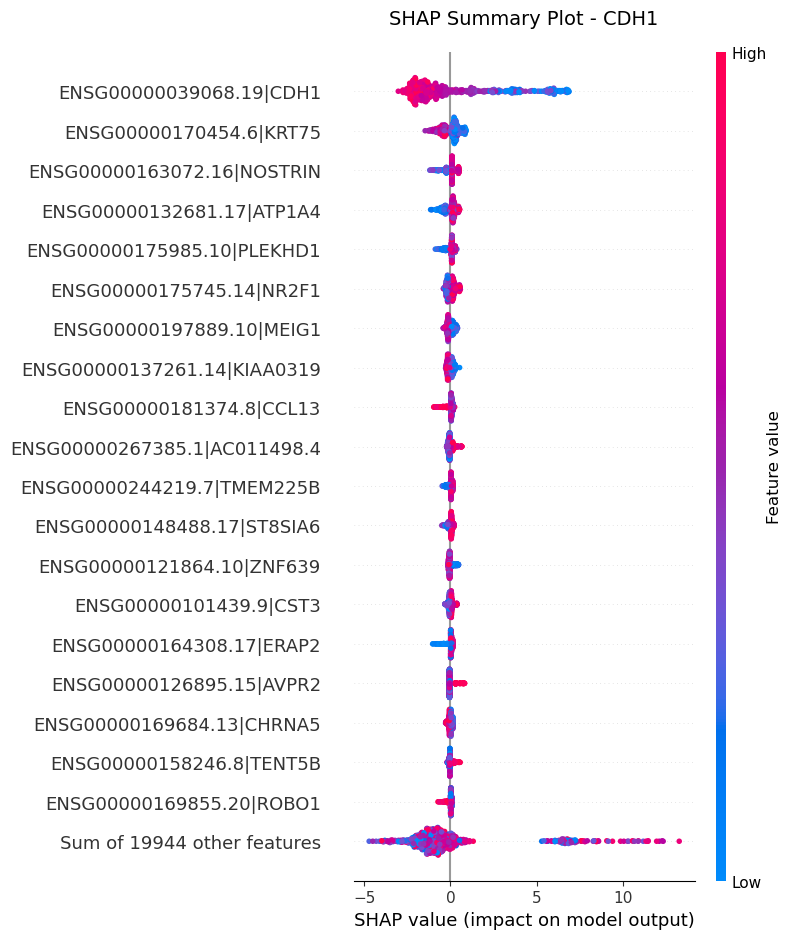

In [ ]:
# Run SHAP Analysis for BRCA with LightGBM (separate model per gene)
for cancer in ['ACC','BLCA','BRCA','CESC','CHOL','COAD','ESCA','GBM','HNSC','KICH',
 'KIRC','KIRP','LGG','LIHC','LUAD','LUSC','MESO','OV','PAAD','PCPG',
 'PRAD','READ','SARC','SKCM','STAD','TGCT','THCA','THYM','UCEC','UVM']:
    print("="*60)
    print("Running SHAP Analysis with LightGBM for BRCA")
    print("="*60)
    
    data_load = data_loader.TCGADataLoader(use_cache=False)
    data_load.config['data']['min_mutations_per_gene'] = 0.02
    # Load and preprocess data for the selected cohorts
    print(f"Loading and preprocessing data for: {', '.join(selected_cohorts)}")
    expression_data, mutation_data = data_load.preprocess_data(cancer_types=selected_cohorts)

    results_root = Path("../results/notebook_multitask_test") / cancer
    # Preprocess data
    X_log = np.log1p(expression_data)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_log)
    X_scaled_df = pd.DataFrame(X_scaled, index=expression_data.index, columns=expression_data.columns)
    
    # Define chosen genes to explain (modify this list as needed)
    # Example: chosen_genes = ['TP53', 'PIK3CA', 'GATA3']
    # For now, using all genes - replace with your chosen list
    chosen_genes = gene_df.index.tolist()  # Replace with your chosen genes list
    
    print(f"\nChosen genes for SHAP analysis: {chosen_genes}")
    print(f"   Total genes to analyze: {len(chosen_genes)}")
    
    # Import LightGBM directly for single-output models
    import lightgbm as lgb
    
    # Setup output directory for SHAP results
    shap_output_dir = results_root / "shap_analysis"
    shap_output_dir.mkdir(parents=True, exist_ok=True)
    
    # Import SHAP
    try:
        import shap
    except ImportError:
        raise ImportError("SHAP library not available. Install with: pip install shap")
    
    shap_results = {}
    feature_names = X_scaled_df.columns.tolist()
    
    # Train a separate LightGBM model for each chosen gene and compute SHAP
    for idx, gene_name in enumerate(chosen_genes):
        if gene_name not in mutation_data.columns:
            print(f"\n  [{idx+1}/{len(chosen_genes)}] Skipping {gene_name} - not in mutation data")
            continue
        
        print(f"\n  [{idx+1}/{len(chosen_genes)}] Processing {gene_name}...")
        
        try:
            # Get target for this gene
            y_gene = mutation_data[gene_name].values
            
            # Check if gene has both classes
            if len(np.unique(y_gene)) < 2:
                print(f"     Warning: {gene_name} has only one class. Skipping...")
                continue
            
            # Train a separate LightGBM model for this gene
            print(f"     Training LightGBM model for {gene_name}...")
            lgb_model = lgb.LGBMClassifier(
                is_unbalance=True,
                random_state=42,
                verbose=-1,
            )
            lgb_model.fit(X_scaled_df.values, y_gene)
            
            # Create SHAP explainer for this gene's model
            print(f"     Computing SHAP values for {gene_name}...")
            explainer = shap.TreeExplainer(lgb_model)
            shap_values = explainer.shap_values(X_scaled_df.values)
            
            # Handle binary classification output (SHAP returns list for binary)
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values = shap_values[1]  # Get SHAP values for positive class
            
            shap_values = np.array(shap_values)
            
            # Store results
            shap_results[gene_name] = {
                'shap_values': shap_values,
                'feature_names': feature_names,
                'explained_gene': gene_name,
                'explained': X_scaled_df.values,
            }
            
            # Save compact SHAP summary instead of full matrix
            from interpretation.shap_analysis import save_shap_summary
            gene_dir = shap_output_dir / gene_name
            gene_dir.mkdir(exist_ok=True)
            
            # Save summary: top N features per sample with directions
            save_shap_summary(
                shap_values=shap_values,
                feature_names=feature_names,
                sample_ids=X_scaled_df.index,
                output_path=gene_dir / "shap_summary.csv",
                top_n=20,  # Top 20 features per sample
            )
            
            print(f"     ✓ Completed {gene_name}")
            
        except Exception as e:
            print(f"     ✗ Failed for {gene_name}: {e}")
            continue
        
    if len(shap_results) > 0:
        print(f"\nCreating SHAP visualizations for {len(shap_results)} genes...")
        visualize_all_shap_results(
            all_shap_results=shap_results,
            output_dir=shap_output_dir,
            max_features=20,
            include_heatmap=True,
        )
        
        print(f"\n✅ SHAP analysis complete!")
        print(f"   Analyzed {len(shap_results)} genes")
        print(f"   Results saved to: {shap_output_dir}")
    else:
        print(f"\n⚠️  No genes were successfully analyzed")


Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\KMT2C
   Creating model-level visualizations for MAP3K1...
     Vi

In [53]:
# Create visualizations for all genes
if len(shap_results) > 0:
    print(f"\nCreating SHAP visualizations for {len(shap_results)} genes...")
    visualize_all_shap_results(
        all_shap_results=shap_results,
        output_dir=shap_output_dir,
        max_features=50,
        include_heatmap=True,
    )
    
    print(f"\n✅ SHAP analysis complete!")
    print(f"   Analyzed {len(shap_results)} genes")
    print(f"   Results saved to: {shap_output_dir}")
else:
    print(f"\n⚠️  No genes were successfully analyzed")


Creating SHAP visualizations for 16 genes...

Creating model-level SHAP visualizations for 16 genes...
   Creating model-level visualizations for CDH1...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\CDH1
   Creating model-level visualizations for DMD...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\DMD
   Creating model-level visualizations for FLG...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\FLG
   Creating model-level visualizations for GATA3...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\GATA3
   Creating model-level visualizations for HMCN1...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\HMCN1
   Creating model-level visualizations for KMT2C...
     Visualizations saved to ..\results\notebook_multitask_test\BRCA\shap_analysis\KMT2C
   Creating model-level visualizations for MAP3K1...
     Vi

In [205]:
print("Chosen target genes:", chosen_genes)

# ------------------
# 2. Extract strong interactions
# ------------------
threshold = -0.1  # strong negative = strong interaction

edges = []
df = auprc_df[chosen_genes]   # restrict to chosen mutation labels

for src_gene in df.index:
    for tgt_gene in df.columns:
        val = df.loc[src_gene, tgt_gene]

        # Keep only strong negative interactions
        if val < threshold:
            edges.append({
                "source": src_gene,
                "target": tgt_gene,
                "weight": val,          # negative number: more negative = stronger
                "strength": -val        # positive number: larger = stronger
            })

edge_df = pd.DataFrame(edges)

# ------------------
# 3. Save as Cytoscape-ready CSV
# ------------------
output_path = r"C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\mutation_prediction\results\notebook_multitask_test\BRCA\BLCA_interaction_network_threshold_0.1.csv"
edge_df.to_csv(output_path, index=False)

# print(f"Saved {len(edge_df)} edges to {output_path}")
# edge_df.head()

Chosen target genes: ['CDH1', 'DMD', 'GATA3', 'MAP3K1', 'PIK3CA', 'TP53', 'TTN', 'USH2A']


In [213]:
mutations_df = pd.read_csv(r"C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\downloads\TCGA-BRCA.gene-level_absolute.tsv.gz", sep='\t')

In [218]:
full_mutations_df = pd.read_csv(r"C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\mutations_data.csv", index_col=0)

In [206]:
edge_df['target'].value_counts()

target
MAP3K1    1
GATA3     1
Name: count, dtype: int64